## Chapter 3

### MNIST 데이터셋

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)    # MNIST set을 dictionary형태로 불러옴

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
# 70000개의 이미지와 각 이미지별 784개의 특성(28*28 픽셀). 각 특성은 0~255(흰색~검은색)값을 가짐.
print(X.shape, y.shape)

(70000, 784) (70000,)


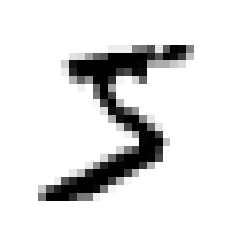

5


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(y[0])


In [4]:
# 문자열 레이블을 정수로 변환
import numpy as np

print(type(y[0]))

y=y.astype(np.uint8)

<class 'str'>


In [5]:
# train/test set 분리.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 이진 분류기

* 5를 감지하는 분류기 만들기

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# SGDClassifier(확률적 경사 하강법) 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# some_digit은 5가 그려진 이미지
sgd_clf.predict([some_digit])

array([ True])

### 성능 측정

In [11]:
# k-fold cross validation 사용
# 성능 측정 지표는 정확도.(95%이상이 나옴)
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# 모든 이미지를 '5가 아님'으로 분류하는 분류기를 만들어 성능 측정
# 그냥 모든 이미지를 5가 아님으로 분류했음에도 정확도가 90%가 넘음. 즉, 정확도는 분류기의 성능 측정 지표로 적절하지 않고, 데이터셋이 불균형하다면 더욱 적절하지 않다.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self;
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [13]:
# 오차 행렬(confusion matrix)로 분류기의 성능 평가
# 클래스 A의 샘플이 클래스 B로 분류된 횟수를 셈(ex. 분류기가 이미지 5를 숫자 3으로 분류한 횟수를 볼려면 오차 행렬의 5행 3열 확인).
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # k-fold cross validation을 수행하면서 평가 점수를 반환하지 않고 각 fold에서 얻은 예측을 반환.

In [14]:
# 오차 행렬 만들기
# 오차 행렬의 행은 실제 클래스, 열은 예측한 클래스를 나타냄.
# 첫 번째 행은 '5가 아님'(negative class, 음성 클래스)을 나타내고 53892개를 5가 아님으로 분류했고(true negative, 진짜 음성) 687개를 5라고 잘못 분류함(false positive, 거짓 양성).
# 두 번째 행은 '5'(positive class, 양성 클래스)를 나타내고 1891개를 5가 아님으로 잘못 분류했고(false negative, 거짓 음성) 3530개를 5라고 분류함(true positive, 진짜 양성).

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
# 분류가 완벽했다면 왼쪽 아래에서 시작하는 대각선 방향의 값은 0이 되어야 한다.
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

> 양성 예측의 정확도를 정밀도(precision)라고 함. 정밀도는 보통 분류기가 정확하게 감지한 양성 샘플의 비율인 재현율(recall, 민감도 또는 진짜 양성 비율)이라는 지표와 같이 사용.    
> 
> <div align="center"><img src="https://latex.codecogs.com/svg.image?precision=\frac{TP}{TP&plus;FP}&space;recall=\frac{TP}{TP&plus;FN}" title="precision=\frac{TP}{TP+FP} recall=\frac{TP}{TP+FN}" /></div>    
> 
> * TP : 진짜 양성의 수    
> * FP : 거짓 양성의 수    
> * FN : 거짓 음성의 수    

In [16]:
# sklearn으로 정밀도와 재현율 계산
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


> 정밀도와 재현율을 하나로 표현한 것을 F1점수라고 함(정밀도와 재현율의 조화 평균).    
> <div align="center"><img src="https://latex.codecogs.com/svg.image?F_{1}&space;=&space;\frac{2}{\frac{1}{precision}&space;&plus;&space;\frac{1}{recall}}&space;=&space;\frac{TP}{TP&space;&plus;&space;\frac{FN&space;&plus;&space;FP}{2}}" title="F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}" /></div>

In [17]:
# f1 score 계산. 상황에 따라 정밀도, 재현율, f1 score중 알맞은 것을 선택하여 평가해야함.
# 재현율이 높으면 진짜 양성의 수가 높아지는 대신 잘못된 판단을 할 확률이 높아지고, 정밀도가 높으면 잘못된 판단을 거의 하지 않는 대신 올바른 판단의 수도 어느정도 줄어든다.
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
# 정밀도와 재현율은 반비례 관계(정밀도/재현율 트레이드오프 라고 함)
# SGDClassifier는 결정 함수를 사용해 각 샘플의 점수를 계산한 뒤, 점수가 임곗값보다 크면 양셩 클래스에 할당함.
# 임곗값이 올라가면 거짓 양성이 진짜 음성이 되어 정밀도가 높아지고(거짓 양성의 수 감소), 임곗값을 내리면 거짓 음성이 진짜 양성이 되어 재현율이 높아짐(거짓 음성의 수 감소)

y_scores = sgd_clf.decision_function([some_digit])  # 주어진 샘플에 대한 점수 계산
threshold = 0                                       # 임곗값
y_some_digit_pred = (y_scores > threshold)

> predict()함수는 decision_function()함수를 이용해 0보다 큰지 판단함.

In [19]:
y_scores

array([2164.22030239])

In [20]:
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

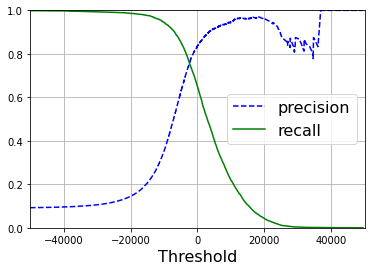

In [22]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # 예측 결과가 아닌 각 샘플에 대한 점수 반환

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)               # 모든 임곗값에 대한 정밀도,재현율 계산

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

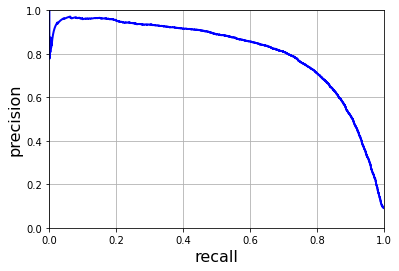

In [23]:
# 재현율, 정밀도 간 그래프. 재현율 80% 근처에서 정밀도 값이 급격히 하락하므로 이 지점 직전을 정밀도/재현율 트레이드오프로 선택함.

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]    # 정밀도가 90%이상이 되는 임곗값의 최소.

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

> 거짓 양성 비율(FPR, 양성으로 잘못 분류된 음성 샘플의 비율)에 대한 진짜 양성 비율(TPR, 재현율)을 나타낸 곡선을 ROC(수신기 조작 특성, receiver operating characteristic)곡선이라고 함.
> * FPR = 1-TNR(진짜 음성 비율, 또는 특이도. 음성으로 정확하게 분류한 음성 샘플의 비율)

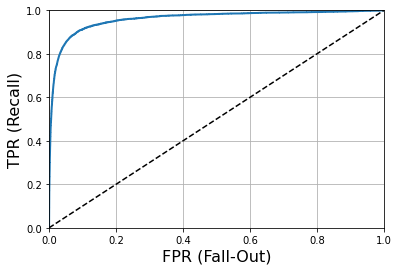

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)   # 여러 임곗값에서 TPR과 FPR을 계산

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR (Fall-Out)', fontsize=16)
    plt.ylabel('TPR (Recall)', fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

# 점선은 랜덤 분류기의 ROC곡선. 좋은 분류기일수록 해당 점선으로부터 멀리 떨어져야함.
# TPR이 높을수록 분류기가 만드는 거짓 양성(FPR)이 증가함.

In [28]:
# ROC 곡선 아래의 면적(AUC, Area Under the Curve)을 측정하여 분류기 비교 가능
# 분류기가 완벽하다면 1, 랜덤 분류기(점선)는 0.5의 값을 가짐.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [29]:
# RandomForestClassifier에 대한 ROC, ROC AUC 계산.
# decision_function()이 없으므로 대신에 predict_proba() (샘플이 주어진 클래스에 속할 확률을 담은 배열 반환) 사용.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")   # 예측 점수 대신 양성 클래스에 속할 확률을 반환

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

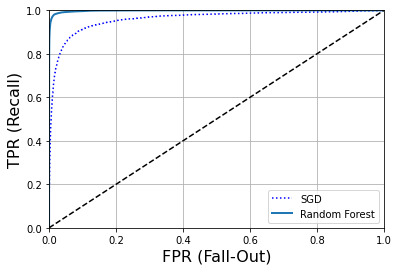

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
# RandomForestClassifier가 SGD보다 좋음.
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 다중 분류
* 여러 개의 클래스를 구별할 수 있는 분류기
  * 여러 개의 이진 분류기를 사용해 다중 클래스를 분류할 수 있음
  * 숫자별 이진 분류기 10개를 만들어 점수가 가장 높은 클래스를 선택. OvR(one versus the rest) 또는 OvA(one versus all)라고 함.
  * 0과 1, 0과 2, ... , 1과 2, ...와 같이 각 숫자의 조합마다 이진 분류기를 훈련시킬 수 있음. OvO(one versus one)라고 함. N개의 클래스가 있다면 N*(N-1)/2개의 분류기가 필요
* OvO는 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 대한 샘플만 필요하다는 장점이 있음.
* 대부분의 경우는 OvR선호

In [25]:
# 이진 분류 알고리즘(여기서는 Support Vector Machine)을 다중 분류에 사용하면 자동으로 OvO, OvR중 선택.
# y_train_5 대신에 y_train 사용

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

NameError: name 'some_digit' is not defined

In [ ]:
# 하나의 샘플당 10개의 점수 반환(OvO)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [37]:
# OvR 쓰도록 강제

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [38]:
len(ovr_clf.estimators_)

10

In [39]:
# SGD는 자동으로 샘플을 다중 클래스로 분류 가능(OvR이나 OvO를 적용하지 않아도 됨.)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [40]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


array([0.87365, 0.85835, 0.8689 ])

In [44]:
# 표준화하여 정확도 상승
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

### 에러 분석

In [24]:
# 오차 행렬 확인

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)

NameError: name 'cross_val_predict' is not defined

In [47]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

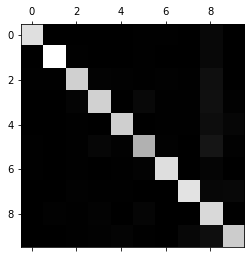

In [48]:
# 오차 행렬 시각화
# 주대각선의 숫자 중 5가 좀 더 어두우므로 5가 잘 분류되지 않았거나 숫자 5에 대한 이미지가 부족하다는 의미.

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

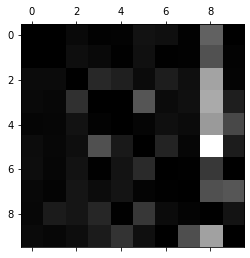

In [49]:
# 에러 비율 확인

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

# 행은 실제 클래스, 열은 예측한 클래스.
# 8 열이 흰색 부분이 많으므로 많은 숫자를 8로 잘못 분류하고 있음을 알 수 있음.
# 3과 5가 서로 혼동되고 있음.
# 오차 행렬은 반드시 대칭이 아닐 수도 있음.

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

> 실제로 8은 아니지만 8처럼 보이는 이미지들을 더 모아서 분류기를 학습시키거나, 분류기에 도움될 만한 특성을 더 많이 찾을 수 있음(ex. 동심원의 수를 세는 알고리즘 추가). 또는 패턴이 드러나도록 이미지 전처리.

In [23]:
# 숫자 그림을 위한 함수(https://github.com/rickiepark/handson-ml2/blob/master/03_classification.ipynb)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# 왼쪽의 5*5 두 블록은 3으로 분류된 이미지, 오른쪽의 5*5 두 블록은 5로 분류된 이미지
# 일부를 제외하고는 3과 5가 구분이 잘 됨(오류가 나는 이유는 SGDClassifier가 선형 모델이기 때문. 클래스마다 픽셀에 가중치를 할당한 뒤, 
# 새로운 이미지에 대해 픽셀 강도의 가중치 합을 클래스의 점수로 계산하므로 5와 3은 몇 픽셀만 다르기 때문에 분류기가 쉽게 혼동함.)
# 이미지를 중앙에 위치시키고 회전되어있지 않드록 전처리하여 분류기가 구분을 더 잘 하도록 할 수 있음.
    
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

NameError: name 'y_train_pred' is not defined

row_sums

### 다중 레이블 분류

In [55]:
# 각 샘플 별로 여러개의 클래스를 출력(ex. 한 사진에 여러 사람이 있을 때, 인식된 사람마다 tag를 붙이는 경우)

# 각 숫자가 큰지(>=7), 홀수인지를 판별. 다중 타겟 배열 y_multilabel은 [bool, bool] 형식으로 순서대로 참의 여부를 저장함.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
# 5는 7보다 크거나 같지 않고, 홀수이다.
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
# 다중 레이블 분류의 평가
# F1 score 사용. 모든 레이블의 가중치가 같다고 가정(만약, 특정 레이블의 수가 높다면 해당 레이블에 대한 가중치를 두어야 하므로 클래스의 지지도(타겟 레이블에 속한 샘플 수)를 가중치로 줌. (average="weighted"))

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### 다중 출력 분류

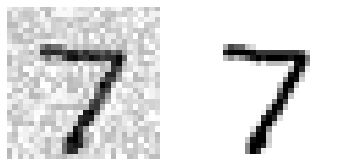

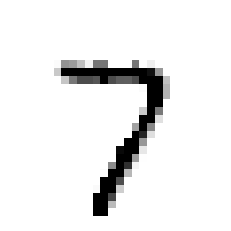

In [64]:
# 다중 레이블 분류에서 한 레이블이 다중 클래스(여러개의 값)가 될 수 있도록 일반화한 것.

# 이미지 노이즈 제거 시스템
# 입력을 잡음이 있는 MNIST 이미지를 받고, 출력은 잡음이 제거된 MNIST 이미지(각 픽셀이 레이블이 되고, 각 레이블당 값을 여러개(픽셀의 강도, 0~255) 가짐.)

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

# 잡음이 낀 7과 잡음 없는 7 이미지 출력
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

# 잡음이 낀 7의 잡음을 제거한 이미지 출력
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

---------------

In [11]:
################
#      ex1     #     
################
# 컴퓨터가 멈춰서 n_jobs는 default
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

kn = KNeighborsClassifier()

param_grid = [
    {'weights': ['distance'], 'n_neighbors': [2, 3, 4]},
]

grid_search = GridSearchCV(kn, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.7s
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.8s
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.5s
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.4s
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=  14.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=  13.8s
[CV] END ....................n_neighbors=3, weights=distance; total time=  13.7s
[CV] END ....................n_neighbors=3, weights=distance; total time=  13.8s
[CV] END ....................n_neighbors=3, weights=distance; total time=  13.9s
[CV] END ....................n_neighbors=4, weights=distance; total time=  16.7s
[CV] END ....................n_neighbors=4, weigh

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4], 'weights': ['distance']}],
             verbose=2)

In [12]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [13]:
grid_search.best_score_

0.9716166666666666

In [16]:
from sklearn.metrics import accuracy_score

pred = grid_search.predict(X_test)
accuracy_score(y_test, pred)

0.9714

In [37]:
################
#      ex2     #     
################
from scipy.ndimage.interpolation import shift

new_img = shift(X_train[0].reshape((28, 28)), [5, 1], cval=0)

KeyboardInterrupt: 

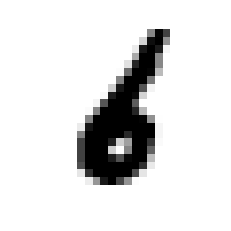

In [8]:
for img in X_train:
    plot_digit(img)

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

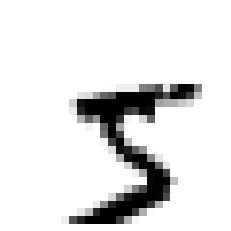

In [38]:
plot_digit(new_img)